In [1]:
# %% import necessary tools
print("import necessary tools")
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import math
import torch
import gpytorch
import pandas as pd
import tqdm as notebook_tqdm

import necessary tools
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
#%% import data
print("import data")
nTrain = 50
df = pd.read_csv('20230628_grainsize.csv')  
df = df.sample(frac=1)
#noises = df.loc[:,"Stdev (%)"]
x = df.iloc[:,1:4]
y = df.loc[:,"Estimated Grain Size (nm)"]
x_train = torch.tensor(np.array(x)[:nTrain,:])
y_train = torch.tensor(np.array(y)[:nTrain])
#noises_train = torch.tensor(np.array(noises)[:nTrain])

import data


In [5]:
#%% pre process data
from sklearn import preprocessing

# scale x training data per standard scaler to N(0,1)
scaler = preprocessing.StandardScaler().fit(x_train)
x_train = torch.tensor(scaler.transform(x_train))

# apply log to y training data and then scale to N(0,1)
y_train = torch.log(y_train)
y_scaler = preprocessing.StandardScaler().fit(y_train.reshape(-1,1))
y_train = torch.tensor(y_scaler.transform(y_train.reshape(-1,1))).squeeze()
print(x_train.size())
print(y_train.size())

torch.Size([50, 3])
torch.Size([50])


In [6]:
#%%
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)

In [7]:
# %%
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

In [8]:
training_iter=200

print('Starting GP parameter tuning...')
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)
    # Calc loss and backprop gradients
    loss = -mll(output, y_train)
    loss.backward()
    if np.mod(i,20)==0:
        #print('Iter %d/%d - Loss: %.3f   lengthscale 1: %.3f   lengthscale 2: %.3f   lengthscale 3: %.3f' % (
         #   i + 1, training_iter, loss.item(),
          #  model.covar_module.base_kernel.lengthscale[0][0].item(),
           # model.covar_module.base_kernel.lengthscale[0][1].item(),
            #model.covar_module.base_kernel.lengthscale[0][1].item(),
        #))
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item()
        ))
    optimizer.step()

Starting GP parameter tuning...
Iter 1/200 - Loss: 1.158   lengthscale: 0.693
Iter 21/200 - Loss: 0.880   lengthscale: 1.277
Iter 41/200 - Loss: 0.879   lengthscale: 1.419
Iter 61/200 - Loss: 0.878   lengthscale: 1.457
Iter 81/200 - Loss: 0.878   lengthscale: 1.455
Iter 101/200 - Loss: 0.878   lengthscale: 1.452
Iter 121/200 - Loss: 0.878   lengthscale: 1.456
Iter 141/200 - Loss: 0.878   lengthscale: 1.456
Iter 161/200 - Loss: 0.878   lengthscale: 1.456
Iter 181/200 - Loss: 0.878   lengthscale: 1.456


In [9]:
x_test = torch.tensor(np.array(x)[nTrain:,:])
x_test = torch.tensor(scaler.transform(x_test))
y_test = torch.log(torch.tensor(np.array(y)[nTrain:]))
y_test = torch.tensor(y_scaler.transform(y_test.reshape(-1,1))).squeeze()
print(y_test)

tensor([ 6.9820e-01, -5.3040e-01, -2.2231e-01, -5.7709e-01, -7.7548e-01,
        -1.4914e-01,  9.9772e-01,  6.0430e-01,  6.1940e-01, -9.4287e-01,
        -3.7901e-01,  1.7341e+00, -3.8754e-01, -6.7928e-01,  6.0233e-01,
        -1.0103e+00, -3.0853e-01, -5.3352e-01,  1.1046e+00,  2.0567e+00,
         2.7858e-01, -1.9425e-02, -1.0991e+00,  2.7783e+00, -3.0196e-01,
        -1.0176e+00, -3.6006e-01,  1.1713e+00, -1.3593e+00,  1.4639e+00,
         1.5503e+00, -2.5136e-01,  2.2425e+00,  7.3281e-01,  2.2750e+00,
         7.2692e-01, -3.1774e-01,  1.5433e+00,  2.1574e+00,  2.1543e+00,
        -1.4113e+00, -5.3779e-01, -2.2953e-01, -1.9754e-01,  1.0547e+00,
        -3.1050e-01, -7.3961e-01, -8.3989e-01, -2.1313e-01, -2.3125e-01,
         2.5971e+00, -8.1687e-01, -1.2672e+00, -8.6190e-01, -4.6865e-01,
         6.1261e-01,  2.5507e+00, -1.3612e+00,  9.7730e-01,  4.9653e-01,
        -3.1780e-01, -2.3554e-01, -6.2950e-01,  1.1735e+00,  2.9279e+00,
         1.8380e+00, -2.7332e-01, -2.1313e-01, -9.2

In [10]:
model.eval()
with torch.no_grad():
    trained_pred_dist = likelihood(model(x_test))
    predictive_mean = trained_pred_dist.mean
    lower, upper = trained_pred_dist.confidence_region()
print(predictive_mean)

tensor([ 1.1047, -0.4448, -0.4346, -0.7058, -0.9078, -0.3112,  0.8431, -0.3112,
         1.1047, -0.4448, -0.4448,  0.8431, -0.4448, -0.9078,  1.1047, -0.7587,
        -0.2736, -0.4448,  1.8376,  1.9464, -0.4346, -0.4448, -0.7058,  0.8431,
        -0.4448, -0.9078, -0.3112,  1.8376, -0.7587,  1.8376,  1.9464, -0.3290,
         1.8376,  1.1047,  0.8431,  1.1047, -0.9078,  0.8431,  1.9464,  1.9464,
        -0.7587, -0.3290, -0.3025, -0.4346,  1.8376, -0.3112, -0.7058, -0.7058,
        -0.4346, -0.3025,  1.8376, -0.9078, -0.9078, -0.7058, -0.2736, -0.4346,
         1.9464, -0.4346,  1.8376,  1.1047, -0.7587, -0.3025, -0.3025,  1.1047,
         1.9464,  1.8376, -0.3025, -0.3290, -0.3112, -0.4346, -0.7587, -0.7058,
         1.8376, -0.3112, -0.3112, -0.3112,  1.8376, -0.4448, -0.4346, -0.4448,
         0.8431,  0.8431, -0.7587, -0.7587,  0.8431,  0.8431, -0.2736, -0.2736,
         1.9464, -0.4448, -0.9078, -0.4346,  0.8431, -0.3112, -0.7587, -0.4448,
        -0.7058, -0.2736, -0.4346, -0.70

In [12]:
final_nlpd = gpytorch.metrics.negative_log_predictive_density(trained_pred_dist, y_test)
#corr = np.corrcoef(predictive_mean,y_train)[0,1]
print(f'nTrained model NLPD: {final_nlpd:.2f}')
#print('Mean predictions correlated: '+str(corr))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [13]:
print(y_test)
print(predictive_mean)
print(lower)
print(upper)

tensor([ 6.9820e-01, -5.3040e-01, -2.2231e-01, -5.7709e-01, -7.7548e-01,
        -1.4914e-01,  9.9772e-01,  6.0430e-01,  6.1940e-01, -9.4287e-01,
        -3.7901e-01,  1.7341e+00, -3.8754e-01, -6.7928e-01,  6.0233e-01,
        -1.0103e+00, -3.0853e-01, -5.3352e-01,  1.1046e+00,  2.0567e+00,
         2.7858e-01, -1.9425e-02, -1.0991e+00,  2.7783e+00, -3.0196e-01,
        -1.0176e+00, -3.6006e-01,  1.1713e+00, -1.3593e+00,  1.4639e+00,
         1.5503e+00, -2.5136e-01,  2.2425e+00,  7.3281e-01,  2.2750e+00,
         7.2692e-01, -3.1774e-01,  1.5433e+00,  2.1574e+00,  2.1543e+00,
        -1.4113e+00, -5.3779e-01, -2.2953e-01, -1.9754e-01,  1.0547e+00,
        -3.1050e-01, -7.3961e-01, -8.3989e-01, -2.1313e-01, -2.3125e-01,
         2.5971e+00, -8.1687e-01, -1.2672e+00, -8.6190e-01, -4.6865e-01,
         6.1261e-01,  2.5507e+00, -1.3612e+00,  9.7730e-01,  4.9653e-01,
        -3.1780e-01, -2.3554e-01, -6.2950e-01,  1.1735e+00,  2.9279e+00,
         1.8380e+00, -2.7332e-01, -2.1313e-01, -9.2

ValueError: x and y must have same first dimension, but have shapes (50,) and torch.Size([149])

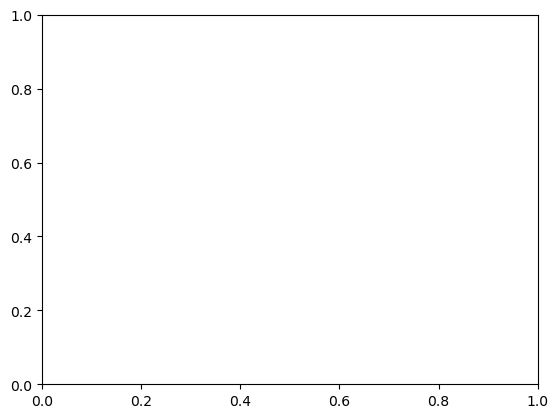

In [14]:
test_size=y_test.size(dim=0)
testInds = np.linspace(0,int(test_size))
plt.figure()
plt.plot(testInds,y_test,'o',label = 'training data')
plt.plot(testInds,predictive_mean,'x',label='predicted mean')
plt.plot(testInds,lower,'-',label = 'lower confidence interval')
plt.plot(testInds,upper,'-',label = 'upper confidence interval')
plt.legend()

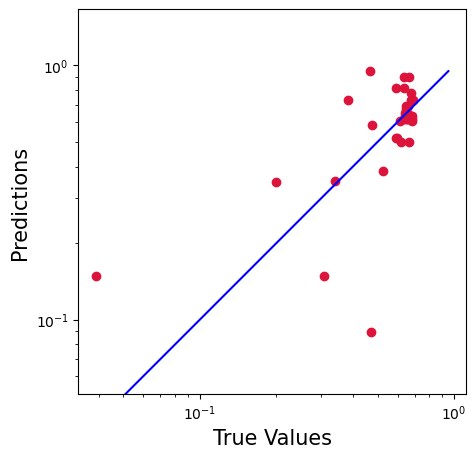

In [13]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, predictive_mean, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predictive_mean), max(y_test))
p2 = min(min(predictive_mean), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

tensor(0.6931, grad_fn=<SelectBackward0>)


IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number